In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import re, os, math, sklearn, datetime, pickle

In [2]:
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### 1. Filter movies with 5 or more ratings

#### Create a dataframe (df_movie_ratings_count_min5) that stores each movie that has more than 4 ratings along with the number of its ratings

Group the ratings_df by the movieId and count the rows with the same movieId

In [5]:
df_movie_ratings_count = df_ratings.groupby('movieId').count()

Keep only the index and the first column and rename the first column for beautifying purposes

In [6]:
df_movie_ratings_count = df_movie_ratings_count.iloc[:,:1]

df_movie_ratings_count.rename(columns = {'userId':'count'}, inplace = True)

In [7]:
df_movie_ratings_count.head(33)

,count
movieId,
1,215
2,110
3,52
4,7
5,49
6,102
7,54
8,8
9,16


#### Remove movies with fewer than 5 ratings

In [8]:
df_movie_ratings_count_min5= df_movie_ratings_count.loc[df_movie_ratings_count['count'] > 4]

In [9]:
df_movie_ratings_count_min5.head(40)

,count
movieId,
1,215
2,110
3,52
4,7
5,49
6,102
7,54
8,8
9,16


In [10]:
df_ratings_min5 = df_ratings.loc[df_ratings['movieId'].isin(df_movie_ratings_count_min5.index)]

In [11]:
df_movies_min5 = df_movies.loc[df_movies['movieId'].isin(df_movie_ratings_count_min5.index)]

In [12]:
print(df_ratings_min5.shape)
print(df_ratings.shape)
print(df_movies_min5.shape)
print(df_movies.shape)
print(df_movies.shape[0]-df_movies_min5.shape[0], "movies have been removed")

(90274, 4)
(100836, 4)
(3650, 3)
(9742, 3)
6092 movies have been removed


#### Check that movies with fewer than 5 ratings have indeed been removed

In [13]:
df_movies.loc[df_movies['movieId']==40]

,movieId,title,genres
36,40,"Cry, the Beloved Country (1995)",Drama


In [14]:
df_ratings.loc[df_ratings['movieId']==40]

,userId,movieId,rating,timestamp
47991,311,40,3.5,1057854804
84607,544,40,5.0,850688776


In [15]:
df_movies_min5.loc[df_movies_min5['movieId']==40]

,movieId,title,genres


In [16]:
df_ratings_min5.loc[df_ratings_min5['movieId']==40]

,userId,movieId,rating,timestamp


### 2. Create the pivot table

In [17]:
merged = df_ratings_min5.merge(df_movies_min5, left_on = 'movieId', right_on = 'movieId', suffixes= ['_user', ''])
merged.drop(columns = ['timestamp','genres'], inplace = True)

In [18]:
merged[300:309]

,userId,movieId,rating,title
300,202,6,5.0,Heat (1995)
301,217,6,2.0,Heat (1995)
302,219,6,3.5,Heat (1995)
303,220,6,3.5,Heat (1995)
304,239,6,5.0,Heat (1995)
305,244,6,5.0,Heat (1995)
306,266,6,4.0,Heat (1995)
307,269,6,5.0,Heat (1995)
308,270,6,3.0,Heat (1995)


In [19]:
merged.isnull().values.any()

False

In [20]:
piv = merged.pivot_table(index=['userId'], columns=['title'], values='rating')

In [21]:
piv.iloc[10:20]

title,"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),102 Dalmatians (2000),12 Angry Men (1957),...,Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),[REC] (2007),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,4.0,NaN,5.0,NaN,NaN,NaN,1.5,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,4.5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
19,2.0,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


### 3. Define prediction functions

In [22]:
"""
Item-based prediction
calculates the weighted average of k similar movies to determine a potential rating for an input user and movie
movie_values: list of the similarities (with values 0-1) of the k nearest movies 
Parameters: movie, user, movie's k nearest neighbours, movie-by-movie similarity table
Returns: item-based prediction
"""
def ib_predicted_rating(movie_name, user, k, item_sim_df):
    sim_movies = item_sim_df.sort_values(by=movie_name, ascending=False).index[1:k+1]  #start index at 1 to avoid including the searched movie in its neighbors
    movie_values = item_sim_df.sort_values(by=movie_name, ascending=False).loc[:,movie_name].tolist()[1:k+1]
    rating_list = []
    weight_list = []
    for j, i in enumerate(sim_movies):
        rating = piv.loc[user, i]
        similarity = movie_values[j]
        if np.isnan(rating):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    
    #sum(weight_list)==0 means that the user has not rated any of the k nearest movies 
    if (sum(weight_list)==0):  
        return np.nan
    else:
        return sum(rating_list)/sum(weight_list)    

In [23]:
"""
User-based prediction
calculates the weighted average of k similar users to determine a potential rating for an input user and movie
Parameters: movie, user, user's k nearest neighbours, user-by-user similarity table
Returns: user-based prediction
"""
def ub_predicted_rating(movie_name, user, k, user_sim_df):
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    user_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:k+1]
    rating_list = []
    weight_list = []
    for j, i in enumerate(sim_users):
        rating = piv.loc[i, movie_name]
        similarity = user_values[j]
        if np.isnan(rating):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
            
    if (sum(weight_list)==0):
        return np.nan
    else:
        return sum(rating_list)/sum(weight_list)  

### 4. Define similarity functions

For the calculation of adjusted cosine similarity the sklearn's cosine similarity will be used but with an adjusted dataset

In [24]:
"""
Given a pivot table P (dataframe) with users as rows and items as columns (or the inverse) and ratings on items as P(i,j)
Removes from every row its average rating and then replaces NaN with 0s. 
Transposes P.
Creates the sparse matrix from the transposed P and calculates the cosine similarith of this matrix
Returns: NxN similarity matrix, where N the rows of the pivot table
"""
from sklearn.metrics.pairwise import cosine_similarity

def adjusted_cosine_similarity(piv):
    
    piv_adj = piv.copy()
    piv_adj = piv_adj.apply(lambda x: (x-np.mean(x)), axis=1) # the average of the row is taken, even if axis=1 
    piv_adj.fillna(0, inplace=True)
    piv_adj_sparse = sp.sparse.csr_matrix(piv_adj.to_numpy())
    return cosine_similarity(piv_adj_sparse)

#adjusted_cosine_similarity(piv)

The Jaccard similarity, $J$, will be computed by finding the Jaccard distance which if we had 2 binary vectors would be given as: $$ d_J = \frac{M_{01}+M_{10}}{M_{01}+M_{10}+M_{11}} = 1 - J$$

In [25]:
"""
Given a pivot table P (dataframe) with users as rows and items as columns (or the inverse) and ratings on items as P(i,j)
Replaces NaN with 0s. 
pdist calculates all the pairwise distances of the elements of the rows (for 610 users there are 185745 combinations between them)
squareform puts in a NxN matrix the calculated pairwise distances
Creates the sparse matrix from the transposed P and calculates the cosine similarith of this matrix
Returns: NxN similarity matrix, where N the rows of the pivot table
"""
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

def jaccard_similarity(piv):
    piv_jac = piv.copy()
    piv_jac.fillna(0, inplace=True)
    piv_jac.to_numpy()
    jaccard_distances = pdist(piv_jac, metric='jaccard')
    #combs=(combinations(range(piv_jac.shape[0]),2))
    #print("Sum of combinations",sum(1 for e in combs))
    jaccard_distances = squareform(jaccard_distances)
    jaccard_similarity = 1-jaccard_distances
    return jaccard_similarity

#jaccard_similarity(piv)

In [26]:
"""
Parameters: piv (pivot table), experiment ('jaccard|adjusted','adjusted|adjusted')
Defines: two dataframes; 1.showing the similarity between items and 2.showing the similarity between users
"""
def define_similarity_matrices(piv,experiment):
    
    if (experiment=='jaccard|adjusted'):
    
        item_similarity_jaccard = jaccard_similarity(piv.T)
        item_sim_jac_df = pd.DataFrame(item_similarity_jaccard, index = piv.columns, columns = piv.columns)
        user_similarity_adjusted = adjusted_cosine_similarity(piv)
        user_sim_adj_df = pd.DataFrame(user_similarity_adjusted, index = piv.index, columns = piv.index)
        print("jac item df shape",item_sim_jac_df.shape)
        print("adj user df shape",user_sim_adj_df.shape)
        
        return (item_sim_jac_df, user_sim_adj_df)
        
    elif (experiment=='adjusted|adjusted'):
        
        item_similarity_adjusted = adjusted_cosine_similarity(piv.T)
        item_sim_adj_df = pd.DataFrame(item_similarity_adjusted, index = piv.columns, columns = piv.columns)
        user_similarity_adjusted = adjusted_cosine_similarity(piv)
        user_sim_adj_df = pd.DataFrame(user_similarity_adjusted, index = piv.index, columns = piv.index)
        
        print("adj user df shape",user_sim_adj_df.shape)
        print("adj item df shape",item_sim_adj_df.shape)
        
        return (item_sim_adj_df, user_sim_adj_df)


### 5. Create training sets

#### But first, we need some helper functions

#### In order to create the different training tables (10%, 20%, ... , 90%) a function that calculates the percentage of the table that is filled with ratings will be defined.

In [27]:
"""
Calculates for each column (movie) the completeness of the column (values that are not nan) as a percentage,
then it calculates the mean of all the columns
Parameters: a pivot table
Returns: a percentage of the cells of the pivot table that are not NaN
"""
def table_completeness(piv):
    not_nans=[]
    for j in piv.columns:
        not_nans.append(round(piv.loc[:,j].count()/piv.shape[0]*100, 1)) #divide with the total users number
    return round(np.mean(not_nans),3)

#### At first, a training table that has the 90% of the ratings of the initial pivot table (randomly selected) will be created. The leftover 10% ratings will be used to create the test table which will be the same throught all the experiments

In [28]:
"""
Creates an approximate 90/10 split. This is done by randomly selecting 10% of the ratings in the initial pivot table and removing them
from training table and moving them to the testing table.
With propability 1-(train_percentage + fixing_coefficient) and if a cell is not empty, then, empty the cell of the pivot table
Fixing coefficint empirically calculated to be 0.005 and is added to training percentage to compensate for the
fact that a lot of the randomly chosen cells will be empty in the initial table and thus cannot be removed in
the training table therefore resulting in a larger training table than the one we want
Parameters: pivot table
Returns: 90/10 train-test tables
"""
import random

def initial_split(piv):
    train_piv = piv.copy()
    test_piv = pd.DataFrame().reindex_like(piv)

    for i in train_piv.index-1:
        for j in range(len(train_piv.columns)):
            rand = random.random()
            if (rand<0.095 and not math.isnan(piv.iloc[i,j])):
                train_piv.iloc[i,j] = np.nan
                test_piv.iloc[i,j] = piv.iloc[i,j]
    print("Inital completeness:",table_completeness(piv))
    print("Train90 completeness:",table_completeness(train_piv))
    print("Test10 completeness:",table_completeness(test_piv))

    return (train_piv, test_piv)

In [ ]:
train90, test10 = initial_split(piv)

The splitting works in a stochastic way therefore test10 will be stored because I want to retrieve it for the various experiments and I want it to be exactly the same.

In [102]:
%store train90
%store test10

Stored 'train90' (DataFrame)
Stored 'test10' (DataFrame)


In [29]:
store -r test10

In [30]:
store -r train90

#### The (10%, 20%, ... 80%) training tables will be created from the 90% training table by randomly selecting ratings from it. It is crucial that the (10%, 20%, ... 80%) training tables be created from the 90% and not from the initial in order to avoid data leakage from the test table

In [34]:
def keep_percentage(train_piv, train_percentage):
    subtrain_piv = train_piv.copy()
    
    fixing_coef = 0.005*(10-train_percentage*10)
    prop = 0.9-train_percentage+fixing_coef
    print("Probability",prop)
    for i in train_piv.index-1:
        for j in range(len(train_piv.columns)):
            rand = random.random()
            if (rand<(0.9-train_percentage+fixing_coef) and not math.isnan(train_piv.iloc[i,j])):
                subtrain_piv.iloc[i,j] = np.nan
                
    print("Train"+ str(int(train_percentage*100))+" completeness:",table_completeness(subtrain_piv))
    
    return subtrain_piv

In [35]:
train80 = keep_percentage(train90, 0.8)
train70 = keep_percentage(train90, 0.7)
train60 = keep_percentage(train90, 0.6)
train50 = keep_percentage(train90, 0.5)

Probability 0.10999999999999997
Train80 completeness: 3.271
Probability 0.21500000000000008
Train70 completeness: 2.895
Probability 0.32000000000000006
Train60 completeness: 2.499
Probability 0.42500000000000004
Train50 completeness: 2.108


In [36]:
train40 = keep_percentage(train90, 0.4)
train30 = keep_percentage(train90, 0.3)
train20 = keep_percentage(train90, 0.2)
train10 = keep_percentage(train90, 0.1)

Probability 0.53
Train40 completeness: 1.728
Probability 0.6350000000000001
Train30 completeness: 1.352
Probability 0.74
Train20 completeness: 0.95
Probability 0.8450000000000001
Train10 completeness: 0.574


#### Core functions

In [37]:
"""
For every rating that is NaN in the training table and is not NaN in the test table, make an item-based prediction. 
If the ib prediction is > 2.5 make a user based prediction (otherwise it is too low to make a more sophisticated prediction
and the movie will probably not interest the selected user), add the ub prediction to pred list and add the true rating
that corresponds to the same user and movie to the true list.
Parameters: train table, test table, k neighbours, item similarity matrix, user similarity matrix
"""
def make_predictions(train, test, k, item_sim_df, user_sim_df):
    pred = []
    true = []
    
    print(train.index)
    for i in train.index:
        print("~~~~~~~~~~~~ User " +str(i) +" of 610 ~~~~~~~~~~~~")
        for j in train.columns:
            #print(j)
            if (math.isnan(train.loc[i,j]) and not math.isnan(test.loc[i,j])):
                if (ib_predicted_rating(j, i, k, item_sim_df)>2.5):
                    pred.append(ub_predicted_rating(j, i, k, user_sim_df))
                    true.append(test.loc[i,j])
    return (pred,true)

In [38]:
"""
Combines the creation of the similarity matrices and the making of predictions according to the experiment we want to do.
Parameters: train table, test table (both tables with users on rows, movies on columns), k nearest neighbours,
experiment ('jaccard|adjusted','adjusted|adjusted')
Returns: prediction list, true list
"""
def create_model(train, test, k, experiment):
    
    item_sim_df, user_sim_df = define_similarity_matrices(train,experiment) 
    print("item_sim df shape",item_sim_df.shape)
    print("user_sim df shape",user_sim_df.shape)
    
    return (make_predictions(train, test, k, item_sim_df, user_sim_df))

#### Evaluation helper functions

In [39]:
"""
From 2 lists that their indices correspond creates 2 new 'same' lists with no NaN values,
e.g. if it is found that predicted rating for movie1 by user1 is y_pred[0]==NaN (because 
there were not enough similar neighbours) and true rating is y_true[0]==3,
y_pred_watch and y_test_watch must not contain this rating

Parameters: predictions list, true test list
Returns: 2 lists
"""
def remove_nan(y_pred,y_true):
    y_true_watch = []
    y_pred_watch = []
    for i in range(len(y_true)):    #len(y_test)==len(y_true)
            if (not math.isnan(y_true[i]) and not math.isnan(y_pred[i])):
                y_true_watch.append(y_true[i])
                y_pred_watch.append(y_pred[i])
                
    return (y_pred_watch, y_true_watch)

In [45]:
"""
Create 2 lists in order be compared with sklearns's binary classification metrics
Parameters: predictions list, true test list
Returns: 2 lists like the given but with values in the binary range
"""

def prepare_for_binary_evaluation(y_pred,y_test):
    binary_y_test_watch = []
    binary_y_pred_watch = []
    for i in range(len(y_test)):
        if (y_test[i]>3.5):
            binary_y_test_watch.append(1)
        else:
            binary_y_test_watch.append(0)
        if (y_pred[i]>3.5):
            binary_y_pred_watch.append(1)
        else:
            binary_y_pred_watch.append(0)
            
    return (binary_y_pred_watch, binary_y_test_watch)

<br />

### 6. Experiments

#### 1A) K = 20, train = 10%

In [41]:
y_pred1A, y_true1A = create_model(train10,test10,20,'jaccard|adjusted')

jac item df shape (3650, 3650)
adj user df shape (610, 610)
item_sim df shape (3650, 3650)
user_sim df shape (610, 610)
Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
           dtype='int64', name='userId', length=610)
~~~~~~~~~~~~ User 1 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 2 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 3 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 4 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 5 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 6 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 7 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 8 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 9 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 10 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 11 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 12 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 13 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 14 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 15 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 16 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 17 of 610 ~~~~~~~~~~~

~~~~~~~~~~~~ User 192 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 193 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 194 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 195 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 196 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 197 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 198 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 199 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 200 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 201 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 202 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 203 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 204 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 205 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 206 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 207 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 208 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 209 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 210 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 211 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 212 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 213 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 214 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 215 of 610 ~~~~~

~~~~~~~~~~~~ User 388 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 389 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 390 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 391 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 392 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 393 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 394 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 395 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 396 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 397 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 398 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 399 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 400 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 401 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 402 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 403 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 404 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 405 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 406 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 407 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 408 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 409 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 410 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 411 of 610 ~~~~~

~~~~~~~~~~~~ User 584 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 585 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 586 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 587 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 588 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 589 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 590 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 591 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 592 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 593 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 594 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 595 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 596 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 597 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 598 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 599 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 600 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 601 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 602 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 603 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 604 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 605 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 606 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 607 of 610 ~~~~~

In [69]:
y_pred_watch1A, y_true_watch1A = remove_nan(y_pred1A,y_true1A)
binary_y_pred_watch1A, binary_y_true_watch1A = prepare_for_binary_evaluation(y_pred_watch1A,y_true_watch1A)

In [70]:
from sklearn.metrics import mean_absolute_error, precision_score, recall_score

mae1A = mean_absolute_error(y_true_watch1A, y_pred_watch1A)
precision1A = precision_score(binary_y_true_watch1A, binary_y_pred_watch1A, average='weighted')
recall1A = recall_score(binary_y_true_watch1A, binary_y_pred_watch1A, average='weighted')

print(mae1A)
print(precision1A)
print(recall1A)

0.8063354765873375
0.62445967669264
0.6270828444027223


Implementing the zero rule in order to make an assesment about the MAE value

In [71]:
zero_pred1A = [np.mean(y_true_watch1A)] * len(y_true_watch1A)
mae_zero1A = mean_absolute_error(y_true_watch1A, zero_pred1A)
print(mae_zero1A)

0.7641552950655044


In [82]:
%store y_pred1A
%store y_true1A

Stored 'y_pred1A' (list)
Stored 'y_true1A' (list)


#### 1B) K = 20, train = 20%

In [50]:
y_pred1B, y_true1B = create_model(train20,test10,20,'jaccard|adjusted')

jac item df shape (3650, 3650)
adj user df shape (610, 610)
item_sim df shape (3650, 3650)
user_sim df shape (610, 610)
Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
           dtype='int64', name='userId', length=610)
~~~~~~~~~~~~ User 1 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 2 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 3 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 4 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 5 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 6 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 7 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 8 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 9 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 10 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 11 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 12 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 13 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 14 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 15 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 16 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 17 of 610 ~~~~~~~~~~~

~~~~~~~~~~~~ User 192 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 193 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 194 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 195 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 196 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 197 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 198 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 199 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 200 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 201 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 202 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 203 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 204 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 205 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 206 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 207 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 208 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 209 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 210 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 211 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 212 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 213 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 214 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 215 of 610 ~~~~~

~~~~~~~~~~~~ User 388 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 389 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 390 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 391 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 392 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 393 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 394 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 395 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 396 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 397 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 398 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 399 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 400 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 401 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 402 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 403 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 404 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 405 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 406 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 407 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 408 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 409 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 410 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 411 of 610 ~~~~~

~~~~~~~~~~~~ User 584 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 585 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 586 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 587 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 588 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 589 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 590 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 591 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 592 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 593 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 594 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 595 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 596 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 597 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 598 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 599 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 600 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 601 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 602 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 603 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 604 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 605 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 606 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 607 of 610 ~~~~~

In [66]:
y_pred_watch1B, y_true_watch1B = remove_nan(y_pred1B,y_true1B)
binary_y_pred_watch1B, binary_y_true_watch1B = prepare_for_binary_evaluation(y_pred_watch1B,y_true_watch1B)

In [67]:
mae1B = mean_absolute_error(y_true_watch1B, y_pred_watch1B)
precision1B = precision_score(binary_y_true_watch1B, binary_y_pred_watch1B, average='weighted')
recall1B = recall_score(binary_y_true_watch1B, binary_y_pred_watch1B, average='weighted')

print(mae1B)
print(precision1B)
print(recall1B)

0.7645548515533207
0.6278433842207052
0.6284673010730917


In [68]:
zero_pred1B = [np.mean(y_true_watch1B)] * len(y_true_watch1B)
mae_zero1B = mean_absolute_error(y_true_watch1B, zero_pred1B)
print(mae_zero1B)

0.7671506122415682


In [83]:
%store y_pred1B
%store y_true1B

Stored 'y_pred1B' (list)
Stored 'y_true1B' (list)


#### 1C) K = 20, train = 30%

In [56]:
y_pred1C, y_true1C = create_model(train30,test10,20,'jaccard|adjusted')

jac item df shape (3650, 3650)
adj user df shape (610, 610)
item_sim df shape (3650, 3650)
user_sim df shape (610, 610)
Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
           dtype='int64', name='userId', length=610)
~~~~~~~~~~~~ User 1 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 2 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 3 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 4 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 5 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 6 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 7 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 8 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 9 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 10 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 11 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 12 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 13 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 14 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 15 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 16 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 17 of 610 ~~~~~~~~~~~

~~~~~~~~~~~~ User 192 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 193 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 194 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 195 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 196 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 197 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 198 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 199 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 200 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 201 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 202 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 203 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 204 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 205 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 206 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 207 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 208 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 209 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 210 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 211 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 212 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 213 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 214 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 215 of 610 ~~~~~

~~~~~~~~~~~~ User 388 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 389 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 390 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 391 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 392 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 393 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 394 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 395 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 396 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 397 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 398 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 399 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 400 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 401 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 402 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 403 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 404 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 405 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 406 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 407 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 408 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 409 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 410 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 411 of 610 ~~~~~

~~~~~~~~~~~~ User 584 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 585 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 586 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 587 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 588 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 589 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 590 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 591 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 592 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 593 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 594 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 595 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 596 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 597 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 598 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 599 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 600 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 601 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 602 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 603 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 604 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 605 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 606 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 607 of 610 ~~~~~

In [59]:
y_pred_watch1C, y_true_watch1C = remove_nan(y_pred1C,y_true1C)
binary_y_pred_watch1C, binary_y_true_watch1C = prepare_for_binary_evaluation(y_pred_watch1C,y_true_watch1C)

In [75]:
mae1C = mean_absolute_error(y_true_watch1C, y_pred_watch1C)
precision1C = precision_score(binary_y_true_watch1C, binary_y_pred_watch1C, average='weighted')
recall1C = recall_score(binary_y_true_watch1C, binary_y_pred_watch1C, average='weighted')

print(mae1C)
print(precision1C)
print(recall1C)

0.7536679327628742
0.6379316172137811
0.6394302848575713


In [65]:
zero_pred1C = [np.mean(y_true_watch1C)] * len(y_true_watch1C)
mae_zero1C = mean_absolute_error(y_true_watch1C, zero_pred1C)
print(mae_zero1C)

0.7572624154564397


In [84]:
%store y_pred1C
%store y_true1C

Stored 'y_pred1C' (list)
Stored 'y_true1C' (list)


#### 1D) K = 20, train = 40%

In [72]:
y_pred1D, y_true1D = create_model(train40,test10,20,'jaccard|adjusted')

jac item df shape (3650, 3650)
adj user df shape (610, 610)
item_sim df shape (3650, 3650)
user_sim df shape (610, 610)
Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
           dtype='int64', name='userId', length=610)
~~~~~~~~~~~~ User 1 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 2 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 3 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 4 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 5 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 6 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 7 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 8 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 9 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 10 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 11 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 12 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 13 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 14 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 15 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 16 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 17 of 610 ~~~~~~~~~~~

~~~~~~~~~~~~ User 192 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 193 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 194 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 195 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 196 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 197 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 198 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 199 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 200 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 201 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 202 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 203 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 204 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 205 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 206 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 207 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 208 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 209 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 210 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 211 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 212 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 213 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 214 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 215 of 610 ~~~~~

~~~~~~~~~~~~ User 388 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 389 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 390 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 391 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 392 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 393 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 394 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 395 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 396 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 397 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 398 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 399 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 400 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 401 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 402 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 403 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 404 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 405 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 406 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 407 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 408 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 409 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 410 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 411 of 610 ~~~~~

~~~~~~~~~~~~ User 584 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 585 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 586 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 587 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 588 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 589 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 590 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 591 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 592 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 593 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 594 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 595 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 596 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 597 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 598 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 599 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 600 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 601 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 602 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 603 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 604 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 605 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 606 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 607 of 610 ~~~~~

In [73]:
y_pred_watch1D, y_true_watch1D = remove_nan(y_pred1D,y_true1D)
binary_y_pred_watch1D, binary_y_true_watch1D = prepare_for_binary_evaluation(y_pred_watch1D,y_true_watch1D)

In [76]:
mae1D = mean_absolute_error(y_true_watch1D, y_pred_watch1D)
precision1D = precision_score(binary_y_true_watch1D, binary_y_pred_watch1D, average='weighted')
recall1D = recall_score(binary_y_true_watch1D, binary_y_pred_watch1D, average='weighted')

print(mae1D)
print(precision1D)
print(recall1D)

0.7388027981584139
0.6483933913714482
0.6475268073331027


In [77]:
zero_pred1D = [np.mean(y_true_watch1D)] * len(y_true_watch1D)
mae_zero1D = mean_absolute_error(y_true_watch1D, zero_pred1D)
print(mae_zero1D)

0.7626403151707951


In [85]:
%store y_pred1D
%store y_true1D

Stored 'y_pred1D' (list)
Stored 'y_true1D' (list)


#### 1E) K = 20, train = 50%

In [81]:
y_pred1E, y_true1E = create_model(train50,test10,20,'jaccard|adjusted')

jac item df shape (3650, 3650)
adj user df shape (610, 610)
item_sim df shape (3650, 3650)
user_sim df shape (610, 610)
Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
           dtype='int64', name='userId', length=610)
~~~~~~~~~~~~ User 1 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 2 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 3 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 4 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 5 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 6 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 7 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 8 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 9 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 10 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 11 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 12 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 13 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 14 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 15 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 16 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 17 of 610 ~~~~~~~~~~~

~~~~~~~~~~~~ User 192 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 193 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 194 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 195 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 196 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 197 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 198 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 199 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 200 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 201 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 202 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 203 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 204 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 205 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 206 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 207 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 208 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 209 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 210 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 211 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 212 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 213 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 214 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 215 of 610 ~~~~~

~~~~~~~~~~~~ User 388 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 389 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 390 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 391 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 392 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 393 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 394 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 395 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 396 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 397 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 398 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 399 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 400 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 401 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 402 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 403 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 404 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 405 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 406 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 407 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 408 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 409 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 410 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 411 of 610 ~~~~~

~~~~~~~~~~~~ User 584 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 585 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 586 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 587 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 588 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 589 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 590 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 591 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 592 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 593 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 594 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 595 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 596 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 597 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 598 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 599 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 600 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 601 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 602 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 603 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 604 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 605 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 606 of 610 ~~~~~~~~~~~~
~~~~~~~~~~~~ User 607 of 610 ~~~~~

In [86]:
y_pred_watch1E, y_true_watch1E = remove_nan(y_pred1E,y_true1E)
binary_y_pred_watch1E, binary_y_true_watch1E = prepare_for_binary_evaluation(y_pred_watch1E,y_true_watch1E)

In [ ]:
mae1E = mean_absolute_error(y_true_watch1D, y_pred_watch1D)
precision1E = precision_score(binary_y_true_watch1D, binary_y_pred_watch1D, average='weighted')
recall1E = recall_score(binary_y_true_watch1D, binary_y_pred_watch1D, average='weighted')

print(mae1E)
print(precision1E)
print(recall1E)

In [87]:
%store y_pred1E
%store y_true1E

Stored 'y_pred1E' (list)
Stored 'y_true1E' (list)


In [ ]:
y_pred1F, y_true1F = create_model(train60,test10,20,'jaccard|adjusted')

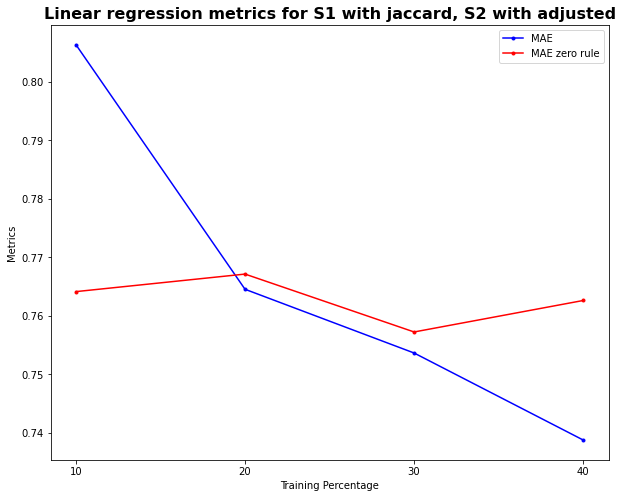

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

plt.title('Linear regression metrics for S1 with jaccard, S2 with adjusted', fontdict={'fontweight':'bold', 'fontsize': 16})
    
perc = [10,20,30,40,50]
mae1_ja = [mae1A, mae1B, mae1C, mae1D, mae1E]
mae_zero1_ja = [mae_zero1A, mae_zero1B, mae_zero1C, mae_zero1D, mae_zero1E]

plt.plot(perc, mae1_ja, 'b.-', label='MAE')
plt.plot(perc, mae_zero1_ja, 'r.-', label='MAE zero rule')

plt.xticks(perc)

plt.xlabel('Training Percentage')
plt.ylabel('Metrics')

plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(10,8))

plt.title('Binary classification metrics for S1 with jaccard, S2 with adjusted', fontdict={'fontweight':'bold', 'fontsize': 16})
    
perc = [10,20,30,40,50]
precision1_ja = [precision1A, precision1B, precision1C, precision1D]
recall1_ja = [recall1A, recall1B, recall1C, recall1D, recall1E]

plt.plot(perc, recall1_ja, 'y.-', label='Recall')
plt.plot(perc, precision1_ja, 'g.-', label='Precision')

plt.xticks(perc)

plt.xlabel('Training Percentage')
plt.ylabel('Metrics')

plt.legend()

plt.show()

#### 1H)  K = 20, train = 80%

In [ ]:
y_pred1H, y_true1H = create_model(train80,test10,20,'jaccard|adjusted')

#### 1I)  K = 20, train = 90%

In [ ]:
y_pred1I, y_true1I = create_model(train90,test10,20,'jaccard|adjusted')

</br>

#### 1J) K = 50, train = 90%

In [ ]:
y_pred1J, y_true1J = create_model(train90,test10,50,'jaccard|adjusted')

In [ ]:
y_pred_watch1J, y_true_watch1B = remove_nan(y_pred1J,y_true1J)
binary_y_pred_watch, binary_y_true_watch = prepare_for_binary_evaluation(y_pred_watch1J,y_true_watch1J)

In [ ]:
print(mean_absolute_error(y_true_watch1J, y_pred_watch1J))
print(precision_score(binary_y_true_watch, binary_y_pred_watch, average='weighted'))
print(recall_score(binary_y_true_watch, binary_y_pred_watch, average='weighted'))

#### 1K) K = 25, train = 90%

In [158]:
item_sim_df, user_sim_df = define_similarity_matrices(train10,'jaccard|adjusted') 
print("item_sim df shape",item_sim_df.shape)
print("user_sim df shape",user_sim_df.shape)

jac item df shape (3650, 3650)
adj user df shape (610, 610)
item_sim df shape (3650, 3650)
user_sim df shape (610, 610)
